In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import random
import sys
import os
from shapely.geometry import MultiPolygon, Point, Polygon
from shapely.ops import cascaded_union
from PIL import Image, ImageFilter
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import namedtuple
if '../ASAP 1.9/bin/' not in sys.path:
    sys.path.append('../ASAP 1.9/bin/')
import multiresolutionimageinterface as mir

In [2]:
def get_list_of_data(imagesP, masksP, xmlsP):
    listofnames=(name.split('.tif')[0] for name in os.listdir(imagesP))
    data=[{'imageP':imagesP+name+'.tif',
           'maskP':masksP+name+'_M.tif',
           'cancerxmlP':xmlsP+name+'.xml',
           'groundxmlP':xmlsP+name+'_G.xml'} for name in listofnames]
    return data

In [3]:
def get_list_of_coordinates(xmlP):
    root = ET.parse(xmlP).getroot()
    annotations=(annot for annot in root.find('Annotations'))
    coordinates=(coord.find('Coordinates') for coord in annotations)
    listXY=(coord.findall('Coordinate') for coord in coordinates)
    XY=[[(int(float(c.attrib['X'])), int(float(c.attrib['Y']))) for c in coords] for coords in listXY]
    return XY

In [4]:
def get_multipolygon(XY):
    return MultiPolygon([[p, []] for p in XY]).buffer(0)

In [5]:
def get_list_random_points(polygon, number):
    counter=0
    points=[]
    minx, miny, maxx, maxy=polygon.bounds
    while counter<number:
        p=Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(p):
            points.append(p)
            counter+=1
    p=[(int(p.coords[0][0]), int(p.coords[0][1])) for p in points]
    return p

In [6]:
def get_data(list_of_data, patch_size, zoom, n):
    c=[]
    cancer=namedtuple('Cancer', ['SlideP', 'MaskP', 'Coord', 'Whiteness'])
    reader = mir.MultiResolutionImageReader()
    for data in tqdm(list_of_data):
        slide = reader.open(data['imageP'])  
        mask = reader.open(data['maskP'])
        cancer_coordinates = get_list_of_coordinates(data['cancerxmlP'])
        ground_coordinates = get_list_of_coordinates(data['groundxmlP'])
        cancer_multipolygon = get_multipolygon(cancer_coordinates)
        ground_multipolygon = get_multipolygon(ground_coordinates)
        merge_points = get_list_random_points(cancer_multipolygon, n) + get_list_random_points(ground_multipolygon, n)
        for xy in merge_points:
            slide_patch = slide.getFloatPatch(startX=xy[0], startY=xy[1], width=patch_size[0], height=patch_size[1], level=zoom)
            slide_patch = slide_patch.astype(np.uint8)
            slide_patch = Image.fromarray(slide_patch).convert('RGB')
            mask_patch = mask.getFloatPatch(startX=xy[0], startY=xy[1], width=patch_size[0], height=patch_size[1], level=zoom)
            mask_patch = mask_patch.astype(np.uint8)
            mask_patch = mask_patch[:, :, 0]
            mask_patch = Image.fromarray(np.uint8(mask_patch)*255)
            mask_patch = mask_patch.convert('L')
            if len(mask_patch.getcolors())==2:
                color=mask_patch.getcolors()[1][0]/262144*100
                c.append(cancer(data['imageP'], data['maskP'], xy, round(color,2)))
            else:
                color=mask_patch.getcolors()[0][1]
                if color==255:
                    c.append(cancer(data['imageP'], data['maskP'], xy, 100.0))
                else:
                    c.append(cancer(data['imageP'], data['maskP'], xy, 0.0))
    return c

In [7]:
d=get_list_of_data('../data/slides/', '../data/masks/', '../data/annotations/')
data=get_data(d, (512,512), 1, 1)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.70it/s]


In [8]:
# zoom=1
# patch_size=(512,512)
# xy=(45419, 32203)
# reader = mir.MultiResolutionImageReader()
# slide = reader.open('../data/slides/1.tif')  
# mask = reader.open('../data/masks/1_M.tif')
# slide_patch = slide.getFloatPatch(startX=xy[0], startY=xy[1], width=patch_size[0], height=patch_size[1], level=zoom)
# slide_patch = slide_patch.astype(np.uint8)
# slide_patch = Image.fromarray(slide_patch).convert('RGB')
# mask_patch = mask.getFloatPatch(startX=xy[0], startY=xy[1], width=patch_size[0], height=patch_size[1], level=zoom)
# mask_patch = mask_patch.astype(np.uint8)
# mask_patch = mask_patch[:, :, 0]
# mask_patch = Image.fromarray(np.uint8(mask_patch)*255)
# mask_patch = mask_patch.convert('L')

In [9]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms as T
import numpy as np
import sys
if '../ASAP 1.9/bin/' not in sys.path:
    sys.path.append('../ASAP 1.9/bin/')
import multiresolutionimageinterface as mir

In [74]:
class CancerDataset(Dataset):
    def __init__(self, data, patch_size, zoom, slide_aug=None, mask_aug=None):
        self.data=data
        self.patch_size=patch_size
        self.zoom=zoom
        self.reader=mir.MultiResolutionImageReader()
        self.slide_aug=slide_aug
        self.mask_aug=mask_aug
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        k=2**self.zoom
        slide=self.reader.open(self.data[index].SlideP)
        mask=self.reader.open(self.data[index].MaskP)
        slide_patch=slide.getFloatPatch(startX=self.data[index].Coord[0]-256*k, 
                                        startY=self.data[index].Coord[1]-256*k, 
                                        width=self.patch_size[0], 
                                        height=self.patch_size[1], 
                                        level=self.zoom)
        slide_patch = slide_patch.astype(np.uint8)
        slide_patch = Image.fromarray(slide_patch).convert('RGB')
        mask_patch=mask.getFloatPatch(startX=self.data[index].Coord[0]-256*k, 
                                        startY=self.data[index].Coord[1]-256*k, 
                                        width=self.patch_size[0], 
                                        height=self.patch_size[1], 
                                        level=self.zoom)
        mask_patch = mask_patch.astype(np.uint8)
        mask_patch = mask_patch[:, :, 0]
        mask_patch = Image.fromarray(np.uint8(mask_patch) * 255)
        mask_patch = mask_patch.convert('L')
        
        return(slide_patch, mask_patch)
#         if self.slide_aug is not None:
#             slide_patch = self.image_aug(slide_patch)
#         else:
#             slide_patch = T.ToTensor()(slide_patch)

#         if self.mask_aug is not None:
#             mask_patch = self.mask_aug(mask_patch)
#         else:
#             mask_patch = T.ToTensor()(mask_patch)
            
#         return slide_patch.share_memory_(), mask_patch.share_memory_()

In [94]:
g=CancerDataset(data, (512,512), 2)

In [78]:
img=g[2][0]

In [272]:
import cv2
def up(x):
    return np.block([[x]*2]*2)

ks = 2
xs = [np.random.randn(16, 16)]
for _ in range(5):
    xs.append(up(xs[-1]) / ks)

def resize(x, size=512):
    area = size * size / (x.shape[0] * x.shape[1])
    xi = cv2.integral(x)
    xi = cv2.resize(xi, (size+1, size+1), interpolation=cv2.INTER_CUBIC)
    x = np.diff(xi, axis=0)
    x = np.diff(x, axis=1)
    return x * area

xs = [resize(x) for x in xs]
xs = sum(xs)

In [294]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3
    
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:,0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1,1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:,1:].repeat(d[0], 0).repeat(d[1], 1)
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:,:,0], grid[:,:,1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:,:,0]-1, grid[:,:,1]-1)) * g11, 2)
    t = f(grid)
    n0 = n00*(1-t[:,:,0]) + t[:,:,0]*n10
    n1 = n01*(1-t[:,:,0]) + t[:,:,0]*n11
    return np.sqrt(2)*((1-t[:,:,1])*n0 + t[:,:,1]*n1)

In [95]:
img=g[1][0]
mask=g[1][1]

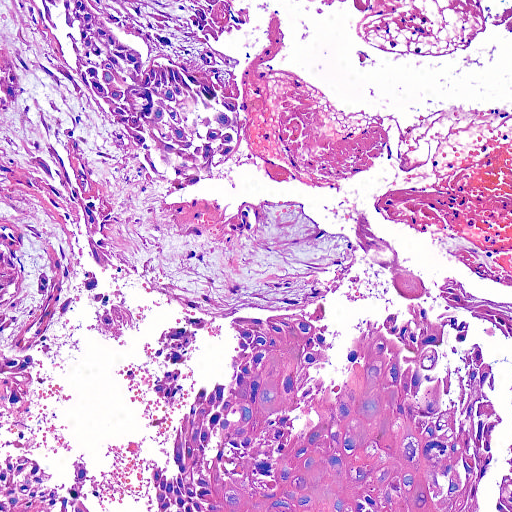

In [99]:
img

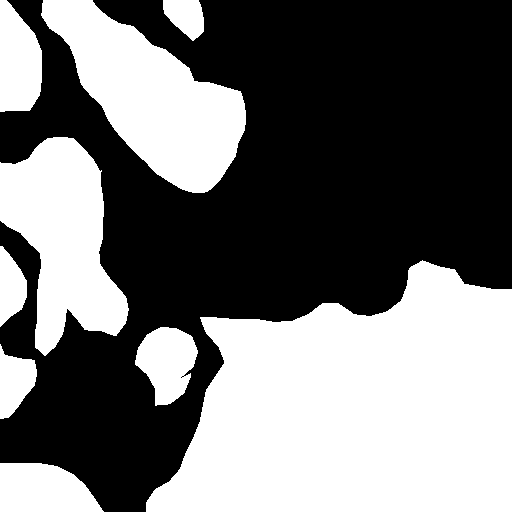

In [97]:
mask